In [1]:
import os
import random
import importlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import myutils
import my_models
from keras.models import Sequential, clone_model
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import image_dataset_from_directory, img_to_array
from keras.activations import linear, relu, sigmoid
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image, ImageOps
from IPython.display import display

importlib.reload(myutils)  # reload the module so changes are applied 
importlib.reload(my_models)  # reload the module so changes are applied 

<module 'my_models' from '/Users/wesleychou/Documents/GitHub/crack-detection/my_models.py'>

In [49]:
SIZE = (32, 32)    # image size
INPUT_SHAPE = (SIZE[0], SIZE[1], 1)  # input shape for CNNs
LR = 0.001    # learning rate
EPC = 10    # epochs

Original dataset consists of two folders, each with 15,000 images. It is obtained from https://www.kaggle.com/datasets/oluwaseunad/concrete-and-pavement-crack-images/code.

I used the `ulimit -n` and `ls | shuf -n 1000 | xargs -I {} cp "{}" ~target/` command to randomly pick 1000 images from each folder. 

They are stored in the `negative` and `positive` folders, under `sample-data`. Negative images have no cracks. Positive images have cracks.
Let's take a look at the images.

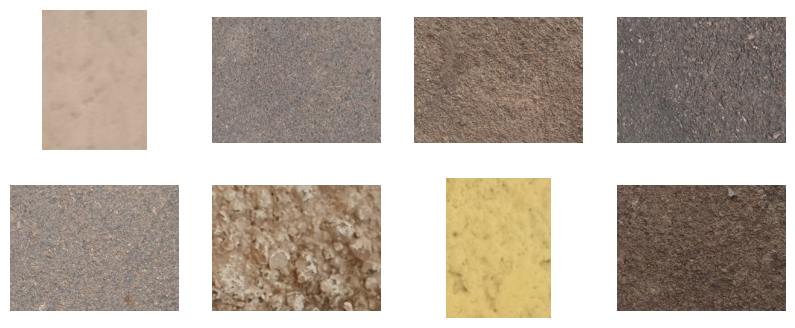

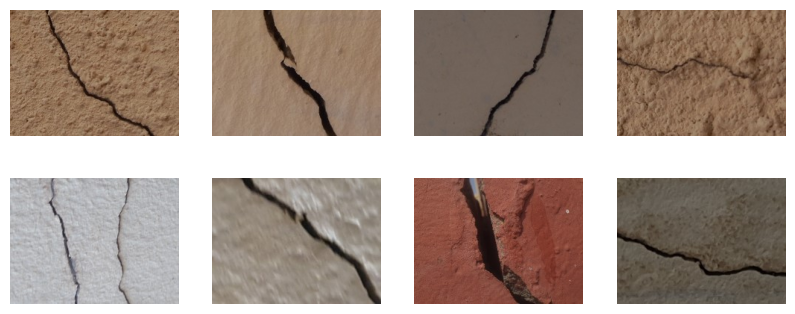

In [3]:
# load images as PIL images
images = shuffle(myutils.load_images('sample-data/negative')) \
    + shuffle(myutils.load_images('sample-data/positive'))

# display the first 8 negative images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis("off")
    
# display the first 8 positive images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i+1000])
    ax.axis("off")

Now we grayscale and resize the images.

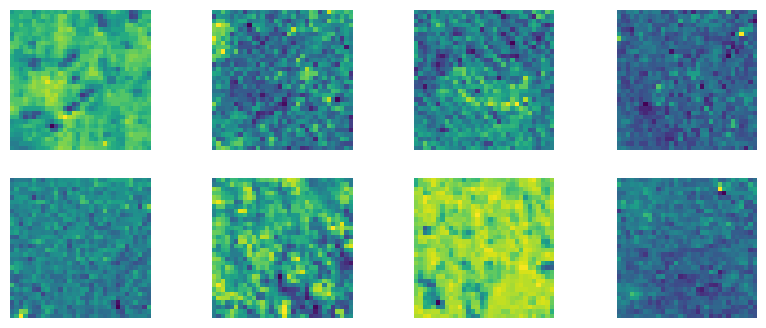

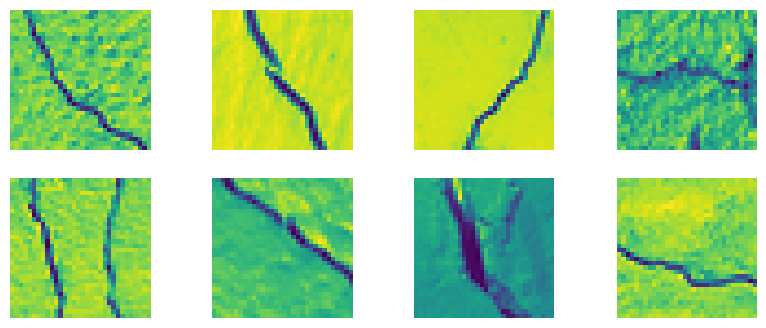

In [4]:
# grayscale and resize the PIL images
images = myutils.grayscale_resize(images, SIZE)

# display the first 8 negative images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis("off")
    
# display the first 8 positive images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i+1000])
    ax.axis("off")

Now we convert the images into numpy arrays. We then normalize the values and shuffle it.

In [5]:
# change PIL images to numpy arrays
X = np.zeros((2000, SIZE[0], SIZE[1]))
y = np.zeros((2000,))

for i, img in enumerate(images):
    X[i] = img_to_array(img).reshape(SIZE)
    y[i] = (0 if i < 1000 else 1)

# normalize image data
X = X / 255.0

# shuffle in unison
X, y = shuffle(X, y, random_state=42)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
X[0][0]

X shape: (2000, 32, 32)
y shape: (2000,)


array([0.53333333, 0.52941176, 0.40392157, 0.36078431, 0.42745098,
       0.49411765, 0.50196078, 0.43137255, 0.43137255, 0.41568627,
       0.39607843, 0.41176471, 0.47058824, 0.48627451, 0.50980392,
       0.55294118, 0.39215686, 0.35294118, 0.42352941, 0.50196078,
       0.50980392, 0.43137255, 0.42352941, 0.50588235, 0.48235294,
       0.35294118, 0.42745098, 0.57647059, 0.57254902, 0.6       ,
       0.55294118, 0.43921569])

Now we split the data into training, cross-validation, and testing sets using a 60-20-20 ratio.

In [6]:
# split data into train, cross-validation, and test
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)
print("Dataset shapes: \n")
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X cv:", X_cv.shape)
print("y cv:", y_cv.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)

Dataset shapes: 

X train: (1200, 32, 32)
y train: (1200,)
X cv: (400, 32, 32)
y cv: (400,)
X test: (400, 32, 32)
y test: (400,)


Let's take a look at the images in our training set.

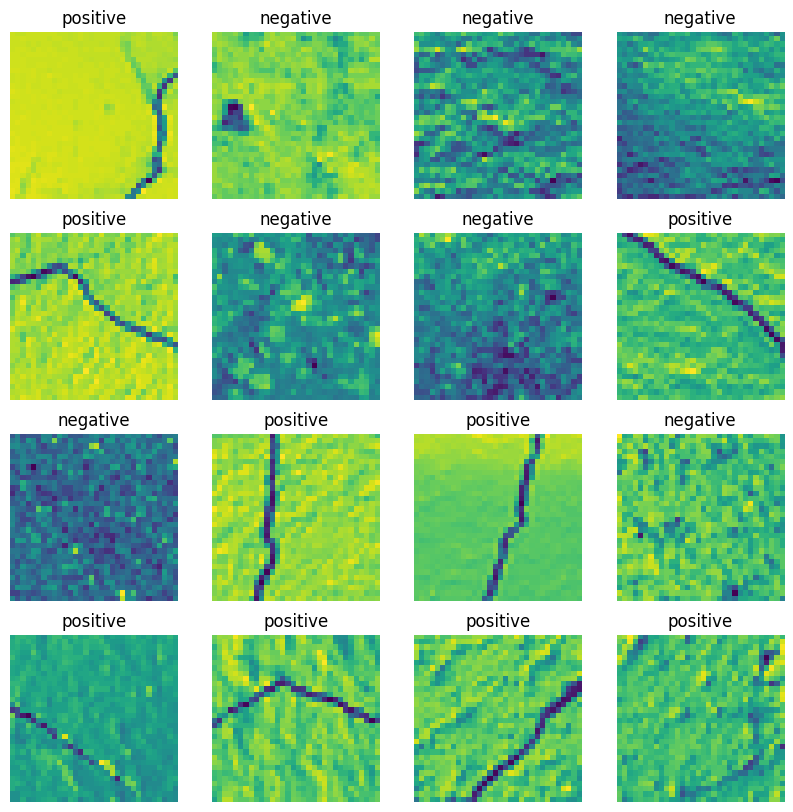

In [7]:
# display the first 16 images in training set
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(SIZE))
    ax.axis("off")
    ax.set_title("positive" if y_train[i]>0 else "negative")

Now we define the model.

In [8]:
# create model
tf.random.set_seed(42)

model = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
)

2023-04-15 11:34:40.395556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
tf.keras.backend.clear_session()

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)
history = model.fit(X_train, y_train, epochs=EPC, validation_data=(X_cv, y_cv))

Epoch 1/10
38/38 [==============================] - 2s 19ms/step - loss: 0.6866 - accuracy: 0.5325 - val_loss: 0.6637 - val_accuracy: 0.7500
Epoch 2/10
38/38 [==============================] - 1s 15ms/step - loss: 0.5550 - accuracy: 0.7442 - val_loss: 0.4741 - val_accuracy: 0.7825
Epoch 3/10
38/38 [==============================] - 1s 17ms/step - loss: 0.4463 - accuracy: 0.8117 - val_loss: 0.4321 - val_accuracy: 0.8375
Epoch 4/10
38/38 [==============================] - 1s 14ms/step - loss: 0.4327 - accuracy: 0.8192 - val_loss: 0.3946 - val_accuracy: 0.8300
Epoch 5/10
38/38 [==============================] - 1s 14ms/step - loss: 0.4115 - accuracy: 0.8258 - val_loss: 0.3800 - val_accuracy: 0.8575
Epoch 6/10
38/38 [==============================] - 1s 14ms/step - loss: 0.3807 - accuracy: 0.8417 - val_loss: 0.3770 - val_accuracy: 0.8225
Epoch 7/10
38/38 [==============================] - 1s 14ms/step - loss: 0.3644 - accuracy: 0.8492 - val_loss: 0.3453 - val_accuracy: 0.8550
Epoch 8/10
38

Evaluate model

Evaluation with cross-validation dataset:

loss = 0.32125455141067505
accuracy = 0.862500011920929


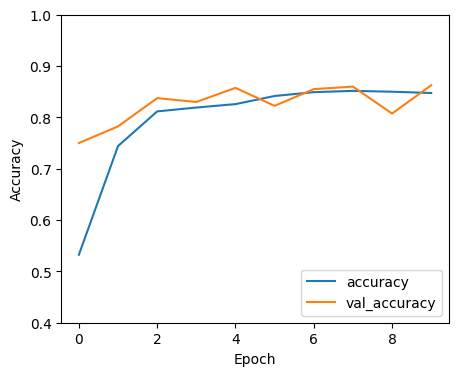

In [10]:
fig = plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

print("Evaluation with cross-validation dataset:\n")
cv_loss, cv_acc = model.evaluate(X_cv, y_cv, verbose=0)
print(f"loss = {cv_loss}\naccuracy = {cv_acc}")

Let's try creating different models and test them out.

In [11]:
tf.keras.backend.clear_session()

mymodels = my_models.MyModels()

# model 1 (this is the original model)
model_1 = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_1", model_1)

# model 2
model_2 = Sequential(
    [
        Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_2", model_2)

# model 3
model_3 = Sequential(
    [
        Conv2D(16, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_3", model_3)

# model 4
model_4 = Sequential(
    [
        Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
mymodels.add_model("model_4", model_4)

mymodels.print_models()

['model_1', 'model_2', 'model_3', 'model_4']


In [ ]:
# mymodels.del_all_models()
# mymodels.print_models()

Evaluate models.


Cross validation metrics:

model_1:
	loss = 0.33522629737854004
	accuracy = 0.862500011920929
model_2:
	loss = 0.21226349472999573
	accuracy = 0.9150000214576721
model_3:
	loss = 0.26355835795402527
	accuracy = 0.8849999904632568
model_4:
	loss = 0.3189557194709778
	accuracy = 0.875


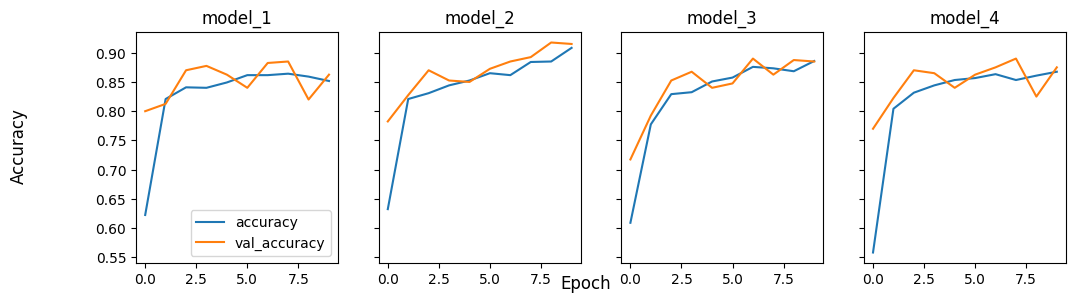

In [12]:
print("\nCross validation metrics:\n")
mymodels.run_and_evaluate(X_train, y_train, X_cv, y_cv, LR, EPC)

We will choose model 2 for its higher accuracy and lower loss.

In [13]:
preferred = "model_2"

model = mymodels.get_model(preferred)
model.summary()

model.save_weights('model.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 128)       

Hyperparameter Tuning

Lets try out different learning rates.

Cross validation metrics:

Learning rate = 0.0001
	loss = 0.41182440519332886
	accuracy = 0.8299999833106995
Learning rate = 0.0005
	loss = 0.3365967571735382
	accuracy = 0.8600000143051147
Learning rate = 0.00075
	loss = 0.3133139908313751
	accuracy = 0.875
Learning rate = 0.001
	loss = 0.31320667266845703
	accuracy = 0.8774999976158142
Learning rate = 0.0025
	loss = 0.2492929846048355
	accuracy = 0.9024999737739563
Learning rate = 0.005
	loss = 0.2555241584777832
	accuracy = 0.9024999737739563
Learning rate = 0.0075
	loss = 0.2641902267932892
	accuracy = 0.8949999809265137
Learning rate = 0.01
	loss = 0.6921683549880981
	accuracy = 0.5199999809265137


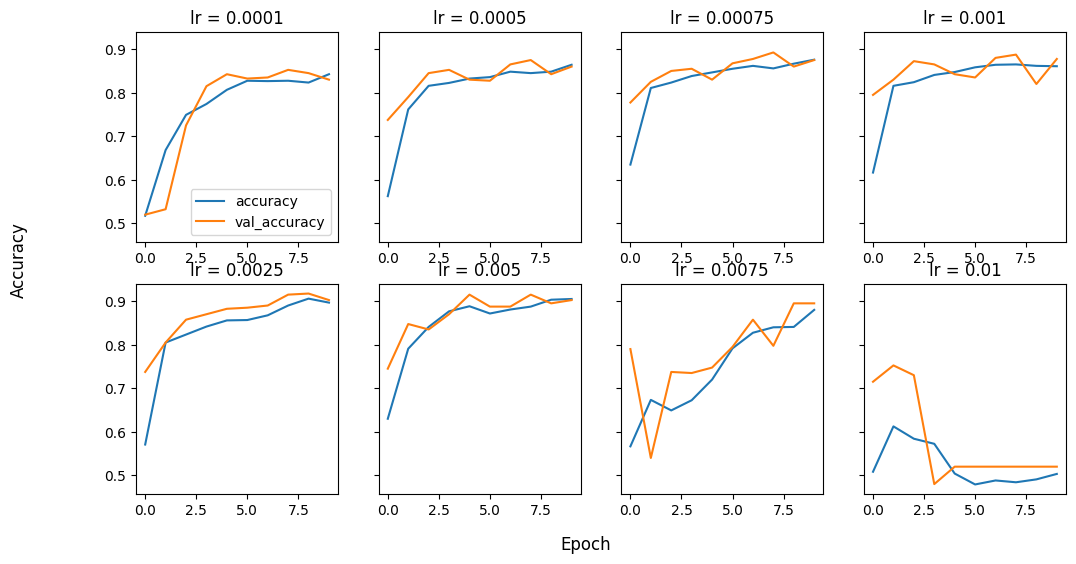

In [54]:
# different learning rate values
learning_rates = [0.0001, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,6), sharey=True)
fig.supylabel('Accuracy')
fig.supxlabel('Epoch')

print("Cross validation metrics:\n")

for i, lr in enumerate(learning_rates):

    # reset the model weights
    test_model = clone_model(model)
    
    test_model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    history = test_model.fit(X_train, y_train, epochs=EPC, 
                        validation_data=(X_cv, y_cv), verbose=0)
    
    row = i//4
    col = i%4
    
    axes[row, col].set_title(f"lr = {lr}")
    axes[row, col].plot(history.history['accuracy'], label='accuracy')
    axes[row, col].plot(history.history['val_accuracy'], label = 'val_accuracy')
    if i==0: axes[row, col].legend()

    cv_loss, cv_acc = test_model.evaluate(X_cv, y_cv, verbose=0)
    print("Learning rate =", lr)
    print(f"\tloss = {cv_loss}\n\taccuracy = {cv_acc}")
    

We can see that the ideal learning rate is somewhere between 0.001 and 0.0075. Let's try some new learning rates within this range.

Cross validation metrics:

Learning rate = 0.0025
	loss = 0.2892317771911621
	accuracy = 0.887499988079071
Learning rate = 0.0035
	loss = 0.2177520990371704
	accuracy = 0.9300000071525574
Learning rate = 0.0045
	loss = 0.22433218359947205
	accuracy = 0.9200000166893005
Learning rate = 0.0055
	loss = 0.31726935505867004
	accuracy = 0.8849999904632568


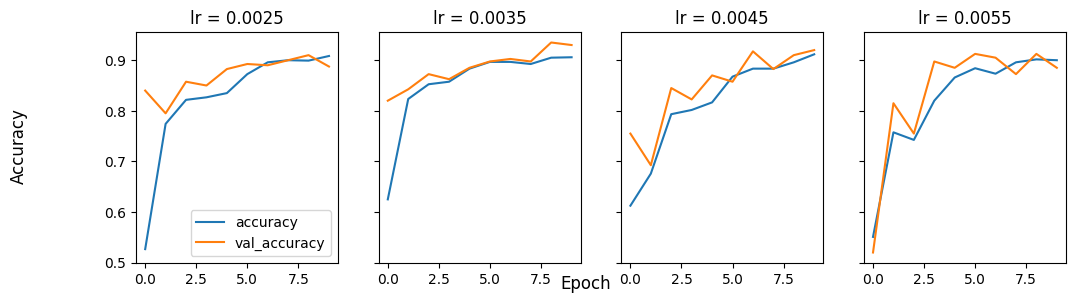

In [58]:
# different learning rate values
learning_rates = [0.0025, 0.0035, 0.0045, 0.0055]

fig, axes = plt.subplots(ncols=4, figsize=(12,3), sharey=True)
fig.supylabel('Accuracy')
fig.supxlabel('Epoch')

print("Cross validation metrics:\n")

for i, lr in enumerate(learning_rates):

    # reset the model weights
    test_model = clone_model(model)
    
    test_model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
    history = test_model.fit(X_train, y_train, epochs=EPC, 
                        validation_data=(X_cv, y_cv), verbose=0)
    
    axes[i].set_title(f"lr = {lr}")
    axes[i].plot(history.history['accuracy'], label='accuracy')
    axes[i].plot(history.history['val_accuracy'], label = 'val_accuracy')
    if i==0: axes[i].legend()

    cv_loss, cv_acc = test_model.evaluate(X_cv, y_cv, verbose=0)
    print("Learning rate =", lr)
    print(f"\tloss = {cv_loss}\n\taccuracy = {cv_acc}")

We will settle with the learning rate of 0.0035 for its higher accuracy and lower loss. Let's train the model with this learning rate.

In [59]:
# new learning rate
LR = 0.0035
EPC = 50

test_model = clone_model(model)

test_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)
history = test_model.fit(X_train, y_train, epochs=EPC, validation_data=(X_cv, y_cv))

Epoch 1/50
38/38 [==============================] - 2s 32ms/step - loss: 0.6857 - accuracy: 0.5075 - val_loss: 0.5775 - val_accuracy: 0.5200
Epoch 2/50
38/38 [==============================] - 1s 24ms/step - loss: 0.5624 - accuracy: 0.7283 - val_loss: 0.4923 - val_accuracy: 0.7500
Epoch 3/50
38/38 [==============================] - 1s 27ms/step - loss: 0.5598 - accuracy: 0.7133 - val_loss: 0.6075 - val_accuracy: 0.6375
Epoch 4/50
38/38 [==============================] - 1s 24ms/step - loss: 0.4430 - accuracy: 0.8017 - val_loss: 0.3722 - val_accuracy: 0.8525
Epoch 5/50
38/38 [==============================] - 1s 25ms/step - loss: 0.3813 - accuracy: 0.8358 - val_loss: 0.3413 - val_accuracy: 0.8625
Epoch 6/50
38/38 [==============================] - 1s 25ms/step - loss: 0.3195 - accuracy: 0.8683 - val_loss: 0.2685 - val_accuracy: 0.8850
Epoch 7/50
38/38 [==============================] - 1s 27ms/step - loss: 0.2638 - accuracy: 0.8983 - val_loss: 0.2714 - val_accuracy: 0.9025
Epoch 8/50
38

Evaluation with cross-validation dataset:

loss = 0.22033140063285828
accuracy = 0.9275000095367432


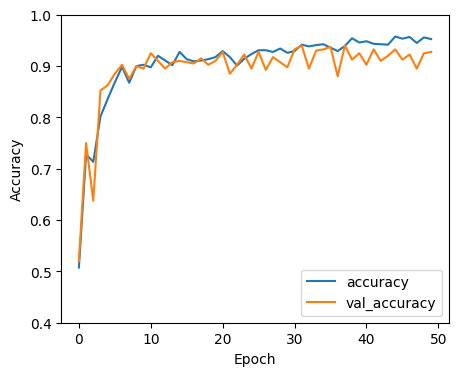

In [60]:
fig = plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1])
plt.legend(loc='lower right')

print("Evaluation with cross-validation dataset:\n")
cv_loss, cv_acc = test_model.evaluate(X_cv, y_cv, verbose=0)
print(f"loss = {cv_loss}\naccuracy = {cv_acc}")

We can see that the `accuracy` and `val_accuracy` begins to diverge after about 20 epochs, with `accuracy` > `val_accuracy`, which is a sign of overfitting. We will train the model again with epochs=20.

Epoch 1/20
38/38 [==============================] - 2s 30ms/step - loss: 0.6479 - accuracy: 0.5750 - val_loss: 0.4977 - val_accuracy: 0.7750
Epoch 2/20
38/38 [==============================] - 1s 28ms/step - loss: 0.4934 - accuracy: 0.7650 - val_loss: 0.4623 - val_accuracy: 0.7850
Epoch 3/20
38/38 [==============================] - 1s 25ms/step - loss: 0.4378 - accuracy: 0.8075 - val_loss: 0.3762 - val_accuracy: 0.8475
Epoch 4/20
38/38 [==============================] - 1s 25ms/step - loss: 0.3408 - accuracy: 0.8625 - val_loss: 0.2909 - val_accuracy: 0.9025
Epoch 5/20
38/38 [==============================] - 1s 25ms/step - loss: 0.2859 - accuracy: 0.8775 - val_loss: 0.2392 - val_accuracy: 0.8950
Epoch 6/20
38/38 [==============================] - 1s 27ms/step - loss: 0.2766 - accuracy: 0.8883 - val_loss: 0.2952 - val_accuracy: 0.8750
Epoch 7/20
38/38 [==============================] - 1s 25ms/step - loss: 0.2737 - accuracy: 0.8950 - val_loss: 0.2912 - val_accuracy: 0.8750
Epoch 8/20
38

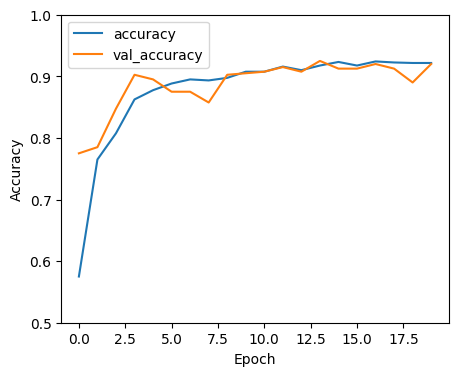

In [69]:
# new epochs value
EPC = 20

final_model = clone_model(model)

final_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR),
    metrics=['accuracy']
)
history = final_model.fit(X_train, y_train, epochs=EPC, validation_data=(X_cv, y_cv))

fig = plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()

We will now test our model using the test dataset.

In [70]:
train_loss, train_acc = history.history['loss'][EPC-1], history.history['accuracy'][EPC-1]
cv_loss, cv_acc = history.history['val_loss'][EPC-1], history.history['val_accuracy'][EPC-1]

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
print(f'CV loss: {cv_loss}, CV accuracy: {cv_acc}')
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')

Train loss: 0.201630100607872, Train accuracy: 0.92166668176651
CV loss: 0.23435284197330475, CV accuracy: 0.9200000166893005
Test loss: 0.2056274265050888, Test accuracy: 0.9275000095367432


Our test accuracy comes out to be ~**92.75%**